In [1]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io.wavfile
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
import os

In [15]:
path_file = os.listdir('data/04-11-23')
label = [filesname.replace('.csv', '') for filesname in path_file]

# label
file = {}
for no_label in label:
    data = pd.read_csv(f'data/04-11-23/{no_label}.csv',skiprows=2)
    file[no_label] = data
    globals()[no_label] = data

In [19]:
window_size = 6000
window_step = 1800


file_segmen = []
for no_segmen in range(0,len(label)):
    file[label[no_segmen]].columns = ["ir","waktu"]
    path1 = file[label[no_segmen]][(file[label[no_segmen]].waktu >10)]
    path1 = path1[(path1.waktu <=190)]
    
    for no_window in range(0,len(path1),window_step):
        window = path1[no_window:no_window+window_size]
        file_segmen.append(window)

# NORMALIZE
## VARIANCE BPM & STD BPM

In [50]:
info = []
minmaxx = []
signals = []
data_var = []
data_std = []
ppg_elgendi = []
for no_minmax in range(0,len(file_segmen)):
    minmax = MinMaxScaler(feature_range=(0,1))
    
    path_minmax1 = minmax.fit_transform(file_segmen[no_minmax])
    path_minmax_seg1 = pd.DataFrame(path_minmax1)[1]
    path_minmax_seg1 = nk.ppg_clean(path_minmax_seg1, sampling_rate=100, method='elgendi')
    ppg_elgendi.append(path_minmax_seg1)
    path_minmax_seg1 = pd.DataFrame(path_minmax_seg1)

    signals1, info1 = nk.ppg_process(path_minmax_seg1, sampling_rate=100)

    minmaxx.append(path_minmax_seg1)
    signals.append(signals1)
    info.append(info1)

    data_var.append(float(pd.DataFrame(info1['PPG_Peaks']).diff().var()))
    data_std.append(float(pd.DataFrame(info1['PPG_Peaks']).diff().std()))

C:\Users\MY ASUS\AppData\Local\Temp\ipykernel_7948\3818205109.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data_var.append(float(pd.DataFrame(info1['PPG_Peaks']).diff().var()))
C:\Users\MY ASUS\AppData\Local\Temp\ipykernel_7948\3818205109.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data_std.append(float(pd.DataFrame(info1['PPG_Peaks']).diff().std()))
C:\Users\MY ASUS\AppData\Local\Temp\ipykernel_7948\3818205109.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data_var.append(float(pd.DataFrame(info1['PPG_Peaks']).diff().var()))
C:\Users\MY ASUS\AppData\Local\Temp\ipykernel_7948\3818205109.py:23: FutureWarning: Calling float on a single element Series is deprecated and will 

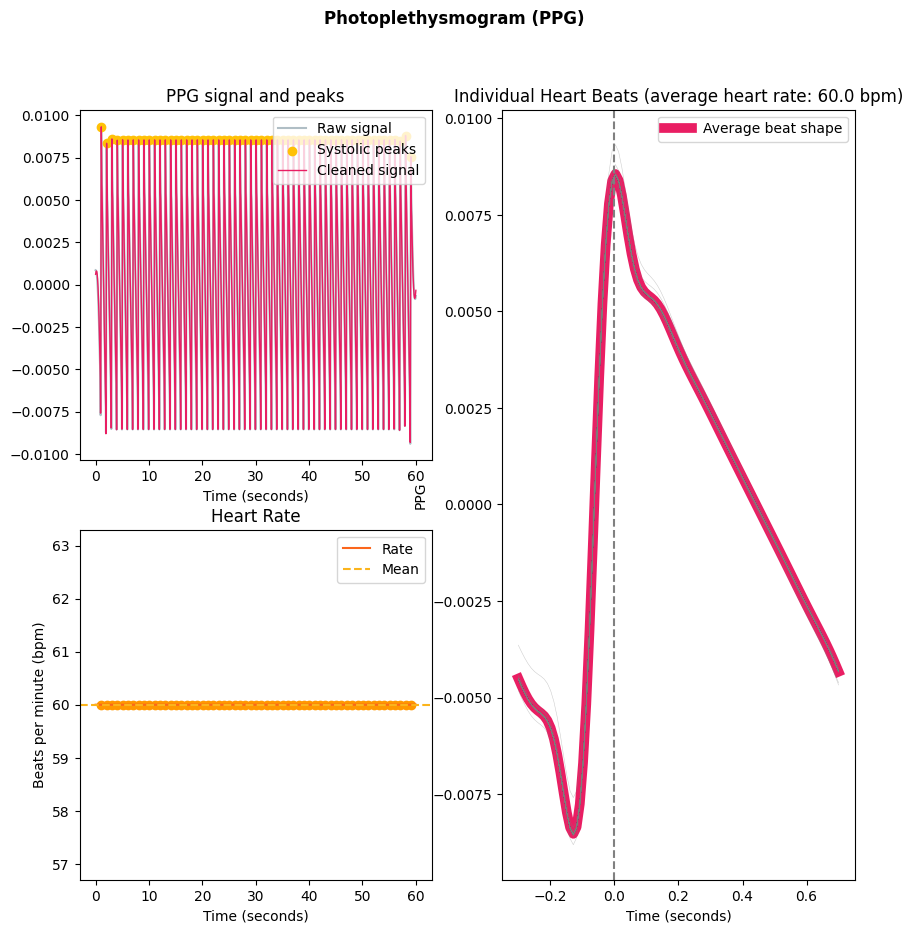

In [48]:
a = (signals[0])
b = (signals[1])
c = (signals[30])

# a['PPG_Clean'].plot()
# b['PPG_Clean'].plot()
# c['PPG_Clean'].plot(title = 'subject1',xlabel = 'n_data',ylabel = 'ppg_sig', color = 'black')
nk.ppg_plot(signals[0], info[0])
# nk.ppg_plot(signals[130], info1[30])
# info[30]

# BPM & HRV

In [64]:
nk.ppg_analyze(signals[60], sampling_rate=100)

C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_time.py:175: RuntimeWarning: invalid value encountered in scalar divide
  out["SDRMSSD"] = out["SDNN"] / out["RMSSD"]  # Sollers (2007)
C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_nonlinear.py:293: RuntimeWarning: divide by zero encountered in scalar divide
  out["CSI"] = L / T
C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_nonlinear.py:294: RuntimeWarning: divide by zero encountered in log10
  out["CVI"] = np.log10(L * T)
C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_nonlinear.py:295: RuntimeWarning: di

ZeroDivisionError: division by zero

In [53]:
analyze_signals = []
bpm = []
hrv = []
rmssd = []
sdnn = []
for no_analyze in range(0,len(file_segmen)):
    analyze_signals1 = nk.ppg_analyze(signals[no_analyze], sampling_rate=100)

#     analyze_signals.append(analyze_signals1)
#     bpm.append(float(analyze_signals1['PPG_Rate_Mean']))
#     hrv.append(float(analyze_signals1['HRV_MeanNN']))
#     rmssd.append(float(analyze_signals1['HRV_RMSSD']))
#     sdnn.append(float(analyze_signals1['HRV_SDNN']))
    
    

C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_time.py:175: RuntimeWarning: invalid value encountered in scalar divide
  out["SDRMSSD"] = out["SDNN"] / out["RMSSD"]  # Sollers (2007)
C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_nonlinear.py:293: RuntimeWarning: divide by zero encountered in scalar divide
  out["CSI"] = L / T
C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_nonlinear.py:294: RuntimeWarning: divide by zero encountered in log10
  out["CVI"] = np.log10(L * T)
C:\Users\MY ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\neurokit2\hrv\hrv_nonlinear.py:295: RuntimeWarning: di

ZeroDivisionError: division by zero